# Rolling and Sigma Clipping

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.stats import sigma_clip

COLOURS = ['cyan', 'orange']

## Test Light Curve

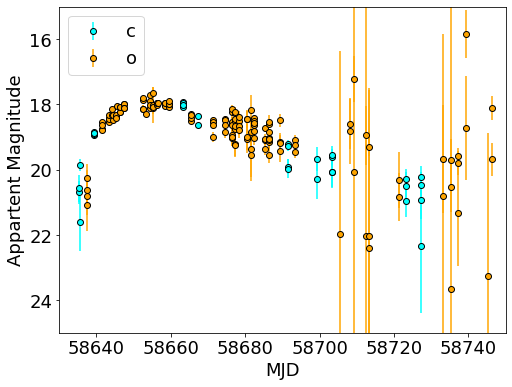

In [8]:
test_df = pd.read_csv('test_lc.csv')

fig, ax = plt.subplots(figsize=(8, 6))
for i, filt in enumerate(test_df.F.unique()):
    filt_df = test_df[test_df.F==filt]
    ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
                fmt='o', label=filt, c=COLOURS[i], mec='k')

ax.set_ylabel('Appartent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

## Pandas Rolling Function

In [9]:
isot_time = Time(test_df.MJD, format='mjd', scale='utc').isot
test_df["time"] = pd.to_datetime(isot_time)
test_df.set_index("time", inplace=True)  # necessary for pandas rolling

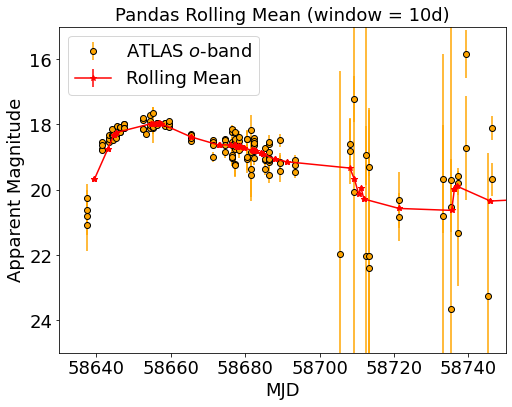

In [72]:
# use only o band as it has more data
filt = 'o'
filt_df = test_df[test_df.F==filt]


fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
            fmt='o', c=COLOURS[1], mec='k', label='ATLAS $o$-band')
# rolling
window = '10d'
center =True
ax.errorbar(filt_df.MJD.rolling(window, center=center).mean(), filt_df.m.rolling(window, center=center).mean(), 
                 yerr=0.0, marker='*', label="Rolling Mean", c='r')

ax.set_ylabel('Apparent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title('ATLAS $o$-band', fontsize=18)
ax.set_title(f"Pandas Rolling Mean (window = {window})", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

## Custom Rolling Function

In [73]:
def custom_rolling(x, y, yerr, time_stamp, window, center=False):
    """Custom rolling functions, similar to pandas
    rolling function. Only uses mean for now.
    
    Parameters
    ----------
    x: array
        X-axis data.
    y: array
        Y-axis data.
    yerr: array
        Y-axis error.
    time_stamp: array
        Time values used by the rolling window.
    window: float
        Time window in the same units as time_stamp.
        
    Returns
    -------
    rolling_y: array
        Rolling data.
    """
    data_dict = {'x':x, 'y':y, 'yerr':yerr}
    rolling_dict = {'x':[], 'y':[], 'yerr':[]}
    
    for i, time in enumerate(time_stamp):
        if center==True:
            roll_time = time_stamp.copy() 
            mask = np.abs(time-roll_time)<=window/2
        else:
            roll_time = time_stamp[:i+1].copy()
            mask = time-roll_time<=window

        for key, values in data_dict.items():
            if center==True:
                roll = values.copy()
            else:
                roll = values[:i+1].copy()
            roll = roll[mask].mean()  # this can be modified to do error propagation
            rolling_dict[key].append(roll)
        
    for key, values in rolling_dict.items():
        rolling_dict[key] = np.array(rolling_dict[key])
    
    return rolling_dict['x'], rolling_dict['y'], rolling_dict['yerr']

In [76]:
# use custom rolling function
window = 10  # days
center = True
time_stamp = filt_df.MJD.copy().values
rolling_results = custom_rolling(filt_df.MJD.values, filt_df.m.values, 
                                   filt_df.dm.values, time_stamp, window, center)

rolling_x, rolling_y, rolling_yerr = rolling_results

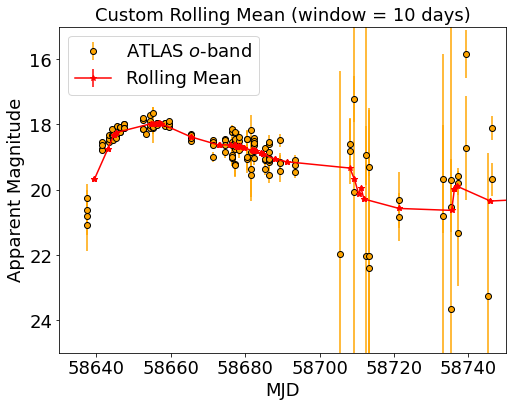

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
            fmt='o', c=COLOURS[1], mec='k', label='ATLAS $o$-band')
# rolling
ax.errorbar(rolling_x, rolling_y, yerr=0.0, 
                    marker='*', label="Rolling Mean", c='r')

ax.set_ylabel('Apparent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title(f"Custom Rolling Mean (window = {window} days)", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

## Comparison

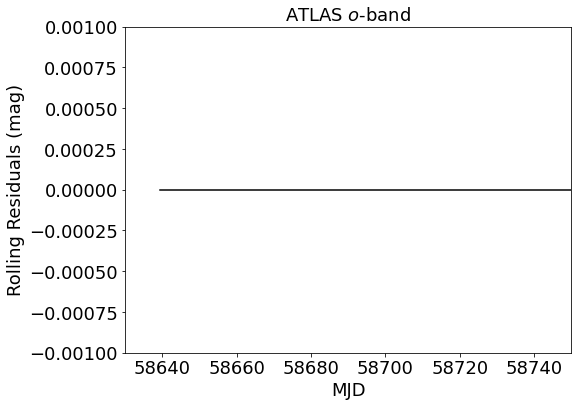

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(rolling_x, rolling_y-filt_df.m.rolling('10d', center=center).mean(), 
            yerr=0.0, label='data', c='k')

ax.set_ylabel('Rolling Residuals (mag)', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title('ATLAS $o$-band', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_xlim(58630, 58750)
ax.set_ylim(-0.001, 0.001)
plt.show()

# Error Propagation

## Weighted Mean

For the weighted mean, the error propgatation can be done in the usual way.

In [45]:
def custom_rolling_improved(x, y, yerr, time_stamp, window):
    """Custom rolling functions, similar to pandas
    rolling function. Only uses mean for now.
    
    Parameters
    ----------
    x: array
        X-axis data.
    y: array
        Y-axis data.
    yerr: array
        Y-axis error.
    time_stamp: array
        Time values used by the rolling window.
    window: float
        Time window in the same units as time_stamp.
        
    Returns
    -------
    rolling_y: array
        Rolling data.
    """
    data_dict = {'x':x, 'y':y, 'yerr':yerr}
    rolling_dict = {'x':[], 'y':[], 'yerr':[]}
    
    for i, time in enumerate(time_stamp):
        roll_time = time_stamp[:i+1].copy()
        mask = time-roll_time<=window
        
        roll_x = data_dict['x'][:i+1].copy()
        roll_x = roll_x[mask].mean()
        rolling_dict['x'].append(roll_x)
        
        roll_y = data_dict['y'][:i+1].copy()
        roll_yerr = data_dict['yerr'][:i+1].copy()
        
        roll_y = np.average(roll_y[mask], weights=1/roll_yerr[mask]**2)
        rolling_dict['y'].append(roll_y)
        
        roll_yerr = np.mean(roll_yerr[mask])  # incorrect error propagation
        rolling_dict['yerr'].append(roll_yerr)
     
    for key, values in rolling_dict.items():
        rolling_dict[key] = np.array(rolling_dict[key])
    
    return rolling_dict['x'], rolling_dict['y'], rolling_dict['yerr']

In [48]:
# use custom rolling function
window = 10  # days
time_stamp = filt_df.MJD.copy().values
rolling_results = custom_rolling_improved(filt_df.MJD.values, filt_df.m.values, 
                                   filt_df.dm.values, time_stamp, window)

rolling_x, rolling_y, rolling_yerr = rolling_results

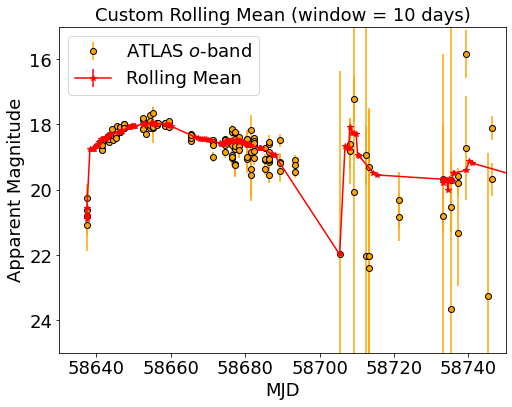

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
            fmt='o', c=COLOURS[1], mec='k', label='ATLAS $o$-band')
# rolling
ax.errorbar(rolling_x, rolling_y, yerr=0.0, 
                    marker='*', label=f"Rolling Mean", c='r')

ax.set_ylabel('Apparent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title(f"Custom Rolling Mean (window = {window} days)", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

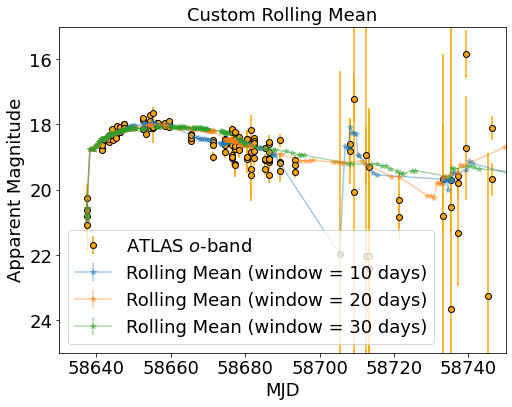

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
            fmt='o', c=COLOURS[1], mec='k', label='ATLAS $o$-band')

for window in [10, 20, 30]:
    time_stamp = filt_df.MJD.copy().values
    rolling_results = custom_rolling_improved(filt_df.MJD.values, filt_df.m.values, 
                                       filt_df.dm.values, time_stamp, window)

    rolling_x, rolling_y, rolling_yerr = rolling_results

    # rolling
    ax.errorbar(rolling_x, rolling_y, yerr=0.0, alpha=0.4, 
                marker='*', label=f"Rolling Mean (window = {window} days)")

ax.set_ylabel('Apparent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title(f"Custom Rolling Mean", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

## Weighted Median

I have found some information:

    https://gist.github.com/tinybike/d9ff1dad515b66cc0d87
    
    https://stackoverflow.com/questions/26102867/python-weighted-median-algorithm-with-pandas

# Sigma Clipping

In [83]:
# Functions taken from https://github.com/transientskp/tkp/blob/master/tkp/utility/sigmaclip.py
# Weighted sigma clipping

def clip(data, mean, sigma, siglow, sighigh, indices=None):
    """Perform kappa-sigma clipping of data around mean
    Args:
        data (numpy.ndarray): N-dimensional array of values
        mean (float): value around which to clip (does not have to be the mean)
        sigma (float): sigma-value for clipping
        siglow (float): lower kappa clipping values
        sighigh (float): higher kappa clipping values
    Kwargs:
        indices (numpy.ndarray): data selection by indices
    Returns:
        (numpy.ndarray) indices of non-clipped data
    """

    if indices is not None:
        ilow = numpy.logical_and(data >= mean - sigma * siglow, indices)
        ihigh = numpy.logical_and(data <= mean + sigma * sighigh, indices)
    else:
        ilow = data >= mean - sigma * siglow
        ihigh = data <= mean + sigma * sighigh
    indices = numpy.logical_and(ilow, ihigh)
    return indices


def calcmean(data, errors=None):
    """Calculate the mean and the standard deviation of the mean"""

    N = len(data)
    if errors is None:
        mean = data.sum() / N
        sigma = numpy.sqrt(((data**2).sum() - N * mean**2) / (N - 1) / N)
    else:
        w = 1. / errors**2
        mean = (w * data).sum() / w.sum()
        sigma = numpy.sqrt(1. / w.sum())
    return mean, sigma


def calcsigma(data, errors=None, mean=None, axis=None, errors_as_weight=False):
    """Calculate the sample standard deviation
    Args:
        data (numpy.ndarray): Data to be averaged. No conversion from
            eg a list to a numpy.array is done.
    Kwargs:
        errors (numpy.ndarray, None): Eerrors for the data. Errors
            needs to be the same shape as data (this is different than
            for numpy.average).  If you want to use weights instead of
            errors as input, set errors_as_weight=True.  If not given,
            all errors (and thus weights) are assumed to be equal to
            1.
        mean (float): Provide mean if you don't want the mean to be
            calculated for you. Pay careful attention to the shape if
            you provide 'axis'.
        axis (int): Specify axis along which the mean and sigma are
           calculated.  If not provided, calculations are done over
           the whole array
        errors_as_weight (bool): Set to True if errors are weights.
    Returns:
        (2-tuple of floats) mean and sigma
    """

    N = data.shape[axis] if axis else len(data)
    if errors is None:
        w = None
    elif errors_as_weight:
        w = errors
    else:
        w = 1.0 / (errors * errors)
    if mean is None:
        # numpy.average does have a weight option, but may
        # not be available in all numpy versions
        mean = ((w * data).sum(axis) / (w.sum(axis))
                if w is not None else data.sum(axis) / N)
    if w is not None:
        V1 = w.sum(axis)
        V2 = (w * w).sum(axis)
        # weighted sample variance
        if axis:
            shape = list(mean.shape)
            shape.insert(axis, 1)
            mmean = numpy.array(mean, copy=0, ndmin=data.ndim).reshape(shape)
        else:
            mmean = mean
        sigma = numpy.sqrt(((data - mmean) * (data - mmean) * w).sum(axis) *
                            (V1 / (V1 * V1 - V2)))
    else:
        # unweighted sample variance
        sigma = numpy.sqrt(((data * data).sum(axis) - N * mean * mean) /
                           (N - 1))
    return mean, sigma


def custom_sigmaclip(data, errors=None, niter=0, siglow=3., sighigh=3.,
              use_median=False):
    """Remove outliers from data which lie more than siglow/sighigh
    sample standard deviations from mean.
    Args:
        data (numpy.ndarray): Numpy array containing data values.
    Kwargs:
        errors (numpy.ndarray, None): Errors associated with the data
            values. If None, unweighted mean and standard deviation
            are used in calculations.
        niter (int): Number of iterations to calculate mean & standard
            deviation, and reject outliers, If niter is negative,
            iterations will continue until no more clipping occurs or
            until abs('niter') is reached, whichever is reached first.
        siglow (float): Kappa multiplier for standard deviation. Std *
            siglow defines the value below which data are rejected.
        sighigh (float): Kappa multiplier for standard deviation. Std *
            sighigh defines the value above which data are rejected.
        use_median (bool): Use median of data instead of mean.
    Returns:
        tuple: (2-tuple) Boolean numpy array of indices indicating which
            elements are clipped (False), with the same shape as the
            input; number of iterations
    """

    # indices keeps track which data should be discarded
    indices = numpy.ones(len(data.ravel()), dtype=numpy.bool).reshape(
        data.shape)
    nniter = -niter if niter < 0 else niter
    i = 0
    for i in range(nniter):
        newdata = data[indices]
        newerrors = errors[indices] if errors is not None else None
        N = len(newdata)
        if N < 2:
            return indices, i
        if use_median:
            mean = numpy.median(newdata)
        else:
            mean = None
        mean, sigma = calcsigma(newdata, newerrors, mean)
        newindices = clip(data, mean, sigma, siglow, sighigh)
        if niter < 0:
            # break when no changes
            if (newindices == indices).all():
                break
        indices = newindices
    return indices, i + 1

In [75]:
def my_clip(ys, sigma):
    clip_mask = ~sigma_clip(ys, sigma=sigma, maxiters=5, cenfunc='median').mask
    
    return clip_mask

def custom_rolling_clipping(x, y, yerr, time_stamp, window, sigma=3, use_custom=False):
    """Custom rolling functions, similar to pandas
    rolling function. Only uses mean for now.
    
    Parameters
    ----------
    x: array
        X-axis data.
    y: array
        Y-axis data.
    yerr: array
        Y-axis error.
    time_stamp: array
        Time values used by the rolling window.
    window: float
        Time window in the same units as time_stamp.
    sigma: float, default `3`
        Sgima for the sigma clipping.
        
    Returns
    -------
    rolling_y: array
        Rolling data.
    """
    data_dict = {'x':x, 'y':y, 'yerr':yerr}
    rolling_dict = {'x':[], 'y':[], 'yerr':[]}
    
    for i, time in enumerate(time_stamp):
        roll_time = time_stamp[:i+1].copy()
        mask = time-roll_time<=window
        
        roll_y = data_dict['y'][:i+1].copy()
        roll_y = roll_y[mask]
        roll_yerr = data_dict['yerr'][:i+1].copy()
        roll_yerr = roll_yerr[mask]
        if not use_custom:
            clip_mask = my_clip(roll_y, sigma)  # this is using sigma clipping on magnitude, but should be fluxes
        else:
            clip_mask, iter_num = custom_sigmaclip(roll_y, roll_yerr, niter=5, siglow=sigma, sighigh=sigma)
        
        roll_y = np.average(roll_y[clip_mask], weights=1/roll_yerr[clip_mask]**2)
        rolling_dict['y'].append(roll_y)
        
        roll_yerr = np.mean(roll_yerr[clip_mask])  # incorrect error propagation
        rolling_dict['yerr'].append(roll_yerr)
        
        roll_x = data_dict['x'][:i+1].copy()
        roll_x = roll_x[mask][clip_mask].mean()
        rolling_dict['x'].append(roll_x)
     
    for key, values in rolling_dict.items():
        rolling_dict[key] = np.array(rolling_dict[key])
    
    return rolling_dict['x'], rolling_dict['y'], rolling_dict['yerr']

/tmp/ipykernel_1330/2564233393.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = numpy.ones(len(data.ravel()), dtype=numpy.bool).reshape(
/tmp/ipykernel_1330/2564233393.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = numpy.ones(len(data.ravel()), dtype=numpy.bool).reshape(
/tmp/ipykernel_1330/2564233393.py:121: Depreca

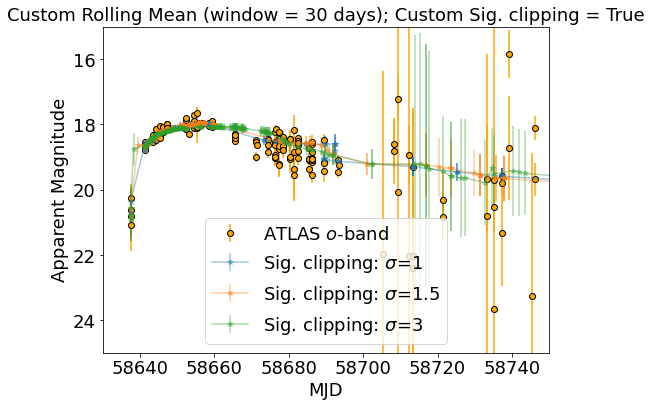

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
            fmt='o', label=r'ATLAS $o$-band', c=COLOURS[1], mec='k')

window = 30  # days
use_custom = True
for sigma in [1, 1.5, 3]:
    time_stamp = filt_df.MJD.copy().values
    rolling_results = custom_rolling_clipping(filt_df.MJD.values, filt_df.m.values, 
                                       filt_df.dm.values, time_stamp, window, sigma, use_custom)

    rolling_x, rolling_y, rolling_yerr = rolling_results

    # rolling
    ax.errorbar(rolling_x, rolling_y, yerr=rolling_yerr, alpha=0.4, 
                        marker='*', label=r"Sig. clipping: $\sigma$="+str(sigma))

ax.set_ylabel('Apparent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title(f"Custom Rolling Mean (window = {window} days); Custom Sig. clipping = {use_custom}", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

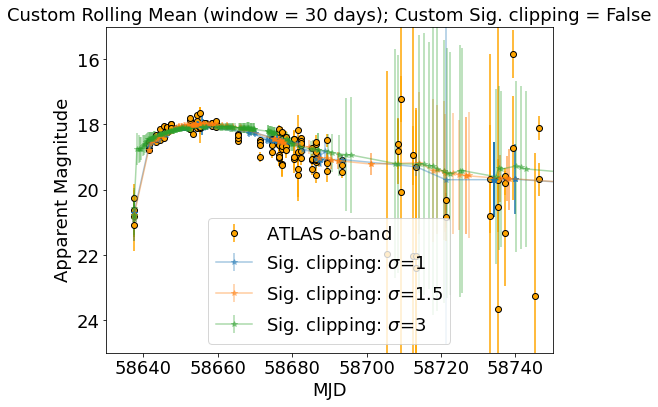

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))

# data
ax.errorbar(filt_df.MJD, filt_df.m, yerr=filt_df.dm, 
            fmt='o', label=r'ATLAS $o$-band', c=COLOURS[1], mec='k')

window = 30  # days
use_custom = False
for sigma in [1, 1.5, 3]:
    time_stamp = filt_df.MJD.copy().values
    rolling_results = custom_rolling_clipping(filt_df.MJD.values, filt_df.m.values, 
                                       filt_df.dm.values, time_stamp, window, sigma, use_custom)

    rolling_x, rolling_y, rolling_yerr = rolling_results

    # rolling
    ax.errorbar(rolling_x, rolling_y, yerr=rolling_yerr, alpha=0.4, 
                        marker='*', label=r"Sig. clipping: $\sigma$="+str(sigma))

ax.set_ylabel('Apparent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.set_title(f"Custom Rolling Mean (window = {window} days); Custom Sig. clipping = {use_custom}", fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(15, 25)
ax.set_xlim(58630, 58750)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()

___
# New Functions

## Weighted Sigma Clipping

In [82]:
# Functions adapted from https://github.com/transientskp/tkp/blob/master/tkp/utility/sigmaclip.py

def clip(data, mean, sigma):
    """Performs sigma clipping of data around mean.
    
    Parameters
    ----------
    data numpy.ndarray: 
        Array of values.
    mean: float
        Value around which to clip (does not have to be the mean).
    sigma: float
        Sigma-value for clipping.
        
    Returns
    -------
    indices: numpy.ndarray
        Indices of non-clipped data.
    """
    ilow = data >= mean - sigma
    ihigh = data <= mean + sigma
    indices = np.logical_and(ilow, ihigh)
    
    return indices


def calc_sigma(data, errors=None):
    """Calculates the weighted standard deviation.
    
    Parameters
    ----------
    data: numpy.ndarray
        Data to be averaged.
    errors: numpy.ndarray, default 'None'
        Errors for the data. If 'None', unweighted
        values are calculated.
        
    Returns
    -------
    wmean: numpy.ndarray
        Weighted mean.
    wsigma: numpy.ndarray
        Weighted standard deviation.
    """
    if errors is None:
        w = 1.0
    else:
        w = 1.0/errors**2
        wmean = np.average(data, weights=w)
    
    V1 = w.sum()
    V2 = (w**2).sum()
    # weighted sample variance
    wsigma = np.sqrt(((data - wmean) * (data - wmean)*w).sum() *
                        (V1 / (V1*V1 - V2)))

    return wmean, wsigma


def weighted_sigmaclip(data, errors=None, niter=0, n_sigma=3, 
                       use_median=False):
    """Remove outliers from data which lie more than n_sigma
    standard deviations from mean.
    
    Parameters
    ----------
    data: numpy.ndarray
        Array containing data values.
    errors: numpy.ndarray, default 'None'
        Errors associated with the data. If 'None', unweighted mean 
        and standard deviation are used in calculations.
    niter: int, default '0' 
        Number of iterations to calculate mean and standard
        deviation, and reject outliers, If niter is negative,
        iterations will continue until no more clipping occurs or
        until abs('niter') is reached, whichever is reached first.
    n_sigma: float, default '3' 
        Number of standard deviations used for sigma clipping.
    use_median: bool, default 'False':
        If 'True', use median of data instead of mean.
        
    Returns
    -------
    indices: boolan numpy.array
        Boolean numpy array of indices indicating which
        elements are clipped (False), with the same shape as the
        input
    i: int
        Number of iterations
    """
    # indices keeps track which data should be discarded
    indices = np.ones(len(data.ravel()), 
                         dtype=np.bool).reshape(data.shape)
    
    if niter < 0:
        nniter = -niter
    else:
        nniter = niter
    
    for i in range(nniter):
        newdata = data[indices]
        if errors is None:
            newerrors = None
        else:
            newerrors = errors[indices]
        
        N = len(newdata)
        if N < 2:
            # no data left to clip
            return indices, i

        mean, sigma = calc_sigma(newdata, newerrors)
        if use_median:
            mean = np.median(newdata)
        newindices = clip(data, mean, n_sigma*sigma)
        
        if niter < 0:
            # break when no changes
            if (newindices == indices).all():
                break
        indices = newindices
        
    return indices, i + 1

## Weighted Rolling

In [83]:
def weighted_rolling(x_data, y_data, yerr_data, window, center=False):
    """Weighted rolling functions, similar to pandas
    rolling function.
    
    Parameters
    ----------
    x_data: array
        X-axis data.
    y_data: array
        Y-axis data.
    yerr_data: array
        Y-axis error.
    window: float
        Time window in the same units as 'x'.
    center: bool, default 'False'
        If 'False', set the window labels as the right 
        edge of the window index. If 'True', set the window 
        labels as the center of the window index.

        
    Returns
    -------
    rolling_y: array
        Rolling data.
    """
    rolling_dict = {'x':[], 'y':[], 'yerr':[]}
    
    for i, x in enumerate(x_data):
        if center==True:
            roll_x = x_data.copy() 
            roll_y = y_data.copy()[mask]
            roll_yerr = yerr_data.copy()[mask]
            mask = np.abs(x-roll_x)<=window/2
        else:
            roll_x = x_data[:i+1].copy()
            roll_y = y_data[:i+1].copy()
            roll_yerr = yerr_data[:i+1].copy()
            mask = x-roll_x<=window
            
        roll_x = roll_x[mask]
        roll_y = roll_y[mask]
        roll_yerr = roll_yerr[mask]
        
        # x-axis
        rolling_dict['x'].append(roll_x.mean())
        # y-axis
        w = 1/roll_yerr**2
        wmean = np.average(roll_y, weights=w)
        rolling_dict['y'].append(wmean)
        # y-error: weighted sample variance
        wvar = np.sum(w * (roll_y - wmean)**2) / np.sum(w)
        wstd = np.sqrt(wvar)
        rolling_dict['yerr'].append(wstd)
        
    # turn lists into arrays    
    for key, values in rolling_dict.items():
        rolling_dict[key] = np.array(rolling_dict[key])
    
    return rolling_dict['x'], rolling_dict['y'], rolling_dict['yerr']